This Kernel uses UNet architecture with ResNet34 encoder, 
* UNet with imagenet pretrained ResNet34 architecture
* Training on Full sized images/masks  
* MixedLoss (weighted sum of Focal loss and dice loss)
* Gradient Accumulution
* APEX Nvidia Driver
* Basic augmentation 



In [0]:
import os
os.listdir("../input")

['siim-dicom-images',
 'siim-acr-pneumothorax-segmentation',
 'stage2train',
 'stage2-test-images',
 'unetrsnet34-19-08-run1',
 'nvidia-apex-15aug2019',
 'siim-png-images']

## Nvidia Driver

In [0]:

!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidia-apex-15aug2019/apex-master/apex-master/

## Import libraries 

In [0]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.torch import ToTensor

from matplotlib.pyplot import figure
from apex import amp
warnings.filterwarnings("ignore")
import random

## Segmentation Model

In [0]:
! pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-f78a175b
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-f78a175b
     |████████████████████████████████| 2.6MB 6.3MB/s 
     |████████████████████████████████| 61kB 19.5MB/s 
     |████████████████████████████████| 1.4MB 31.5MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.0.1-cp36-none-any.whl size=25743 sha256=bcb560cf0954948ca806c3e90ea78d7f41f55ac47b177b492cb64d5821d4321e
  Stored in directory: /tmp/pip-ephem-wheel-cache-l3y0y0t3/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=ec9e1f4fd4b0aa25099cf4fec08c9ec6010b134dd704fdd3ea09f08cea0027b8
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for torchnet: 

## Global Variables 

In [0]:
IMAGE_SIZE =1024
BATCH_SIZE = 16 
EPOCH = 38

## Albumentations

In [0]:

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

## Random seed

In [0]:
SEED = 2390
def seed_all(seed= SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_all(SEED)

## Utility functions

In [0]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

## Dataloader

In [0]:
path2 = "../input/siim-png-images/input/test_png/"
class SIIMDataset(Dataset):
    def __init__(self, df, fnames, data_folder, size, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.gb = self.df.groupby('ImageId')
        self.fnames = fnames

    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        df = self.gb.get_group(image_id)
        annotations = df['EncodedPixels'].tolist()
        image_path = os.path.join(self.root, image_id + ".png")
        image_path1 = os.path.join(path2, image_id + ".png")
        if os.path.isfile(image_path):
            image = cv2.imread(image_path)
        else :
            image = cv2.imread(image_path1) 
        mask = np.zeros([1024, 1024])
        if annotations[0] != '-1':
            for rle in annotations:
                mask += run_length_decode(rle)
        mask = (mask >= 1).astype('float32') # for overlap cases
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
#                 HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )

    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    fold,
    total_folds,
    data_folder,
    df_path,
    phase,
    size,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    print("Phase is ",phase)
    df_all = pd.read_csv(df_path)
    
    print("Size of DF all",df_all.shape)
    df = df_all.drop_duplicates('ImageId')
    print("Size of DF after drop duplicate",df.shape)
    
    df_with_mask = df[df["EncodedPixels"] != "-1"]
    
    print("Size of DF with masks",df_with_mask.shape)
    df_with_mask['has_mask'] = 1
    df_without_mask = df[df["EncodedPixels"] == "-1"]
    
    print("Size of DF without  masks",df_without_mask.shape)
    df_without_mask['has_mask'] = 0
    df_without_mask_sampled = df_without_mask.sample(len(df_with_mask), random_state=69) # random state is imp
    df = pd.concat([df_with_mask, df_without_mask_sampled])
    
    print("shape after all",df.shape)
    #NOTE: equal number of positive and negative cases are chosen.
    
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)
    train_idx, val_idx = list(kfold.split(df["ImageId"], df["has_mask"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    df = train_df if phase == "train" else val_df
    # NOTE: total_folds=5 -> train/val : 80%/20%
    
    fnames = df['ImageId'].values
    #fnames = df['FilePath'].values
    
    image_dataset = SIIMDataset(df_all, fnames, data_folder, size, mean, std, phase)
    #image_dataset = SIIMDataset(df, fnames, data_folder, size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

In [0]:
#sample_submission_path = '../input/siim-acr-pneumothorax-segmentation/sample_submission.csv'
sample_submission_path = '../input/siim-acr-pneumothorax-segmentation/stage_2_sample_submission.csv' 
#train_rle_path = '../input/siim-dicom-images/train-rle.csv'
train_rle_path = '../input/siim-acr-pneumothorax-segmentation/stage_2_train.csv'
data_folder = "../input/siim-png-images/input/train_png/"
#test_data_folder = "../input/siim-png-images/input/test_png"
test_data_folder = "../input/stage2-test-images"

## Losses



In [0]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

## Utility functions
 

In [0]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.mean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (dice, dice_neg, dice_pos, iou))
    return None

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## UNet with ResNet34 model
 

In [0]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
state = torch.load('../input/unetrsnet34-19-08-run1/model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 81.8MB/s]


<All keys matched successfully>

In [0]:
model # a *deeper* look

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Model Training and validation

In [0]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 2}
        self.accumulation_steps = 16
        self.lr = 5e-4
        self.num_epochs = EPOCH
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        
        self.agg_train_loss = []
        self.agg_val_loss = []
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=data_folder,
                df_path=train_rle_path,
                phase=phase,
                size=IMAGE_SIZE,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.net, self.optimizer = amp.initialize(self.net, self.optimizer, opt_level="O1",verbosity=0) 
        
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        print("Starting epoch: %d | phase: %s " % (epoch, phase))
        batch_size = self.batch_size[phase]
        start = time.time()
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                #loss.backward()
                with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                    scaled_loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = running_loss / total_batches
        epoch_log(phase, epoch, epoch_loss, meter, start)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        
        for epoch in range(self.num_epochs):
            train_loss = self.iterate(epoch, "train")
            self.agg_train_loss.append(train_loss)
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.agg_val_loss.append(val_loss)
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")

In [0]:
model_trainer = Trainer(model)
model_trainer.start()

Phase is  train
Size of DF all (12954, 2)
Size of DF after drop duplicate (12047, 2)
Size of DF with masks (2669, 2)
Size of DF without  masks (9378, 2)
shape after all (5338, 3)
Phase is  val
Size of DF all (12954, 2)
Size of DF after drop duplicate (12047, 2)
Size of DF with masks (2669, 2)
Size of DF without  masks (9378, 2)
shape after all (5338, 3)
Starting epoch: 0 | phase: train 



dice: 0.5206 | dice_neg: 0.5464 | dice_pos: 0.4712 | IoU: nan
Starting epoch: 0 | phase: val 



dice: 0.5541 | dice_neg: 0.5084 | dice_pos: 0.3378 | IoU: nan
******** New optimal found, saving state ********
Starting epoch: 1 | phase: train 


## Plot The Loss 

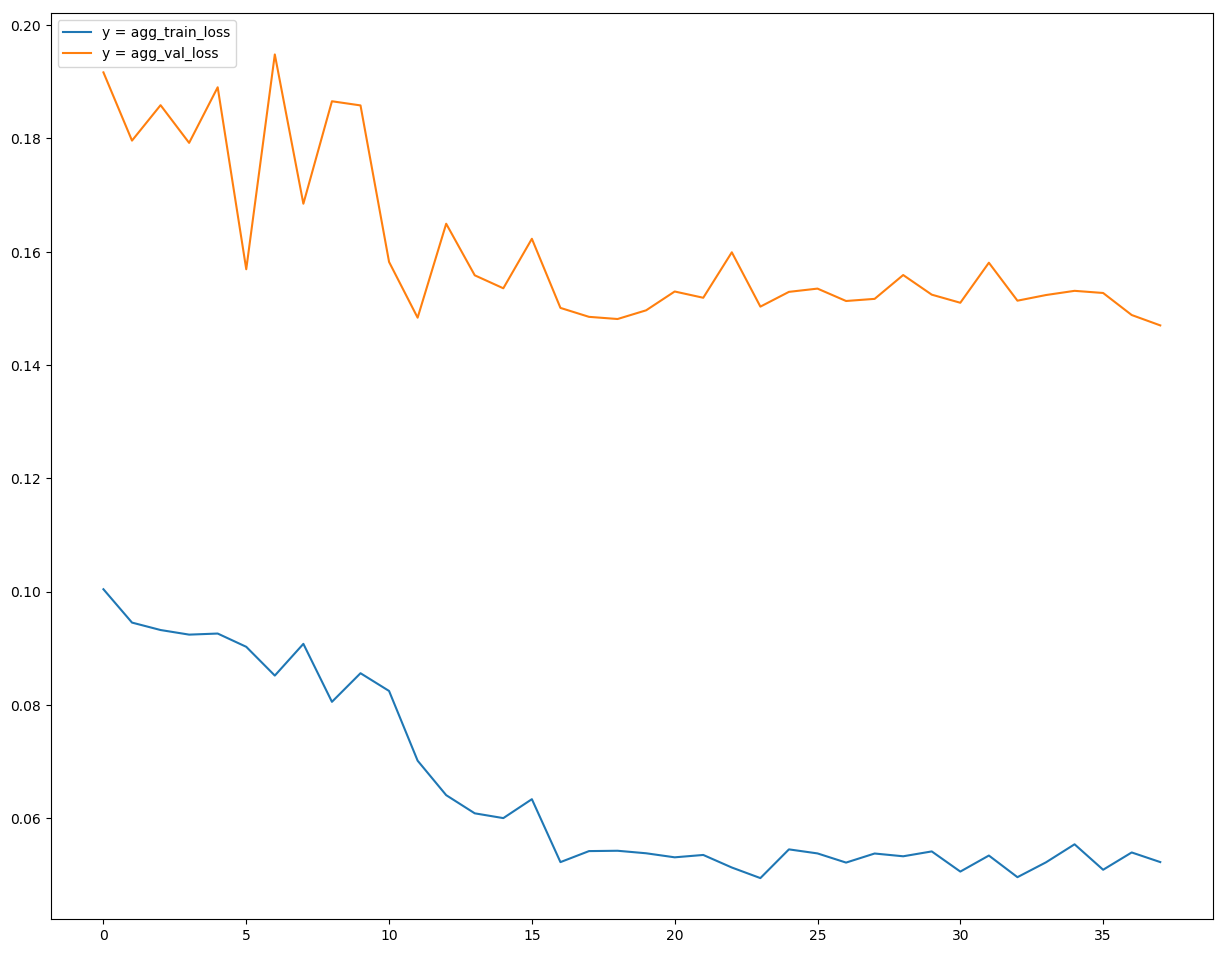

In [0]:
agg_train_loss = model_trainer.agg_train_loss
agg_val_loss = model_trainer.agg_val_loss
figure(num=None, figsize=(15, 12), dpi=100, facecolor='w', edgecolor='k')
plt.plot(agg_train_loss)
plt.plot(agg_val_loss)
#plt.xticks(np.arange(0, len(batch_loss), batch_size)) 
plt.legend(['y = agg_train_loss', 'y = agg_val_loss'], loc='upper left')
plt.show()

## Test prediction

In [0]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".png")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return images

    def __len__(self):
        return self.num_samples

def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [0]:
size = IMAGE_SIZE
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 8
batch_size = 4
best_threshold = 0.5
min_size = 3500
device = torch.device("cuda:0")
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, size, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
model = model_trainer.net # get the model from model_trainer object
model.eval()
state = torch.load('./model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []
for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df['EncodedPixels'] = encoded_pixels
df.to_csv('submission.csv', columns=['ImageId', 'EncodedPixels'], index=False)

In [0]:
df.head()

,ImageId,EncodedPixels
0,ID_0011fe81e,-1
1,ID_9ca06e9b9,-1
2,ID_6f00d6ce6,-1
3,ID_9258110b0,-1
4,ID_fa01c9546,294206 8 1009 26 993 61 960 72 949 81 940 85 9...
